# Regresión espacial

## Introducción 

La regresión (y la predicción de manera más general) nos proporciona un caso perfecto para examinar cómo la estructura espacial puede ayudarnos a comprender y analizar nuestros datos. Por lo general, la estructura espacial ayuda a los modelos de dos maneras:

1. La primera (y más clara) forma en que el espacio puede tener un impacto en nuestros datos es cuando el proceso que generalos datos son en sí mismos explícitamente espaciales. Aquí, piense en algo como los precios de las viviendas unifamiliares. A menudo ocurre que las personas pagan una prima sobre el precio de su casa para vivir en un mejor distrito escolar por la misma calidad de casa. Alternativamente, los hogares más cercanos al ruido o contaminadores químicos, como plantas de tratamiento de aguas residuales, instalaciones de reciclaje o carreteras anchas, en realidad pueden ser más baratos de lo que anticipamos. Finalmente, en casos como la incidencia de asma, los lugares a los que las personas tienden a viajar durante el día, como sus lugares de trabajo o recreación, pueden tener más impacto en su salud que sus direcciones residenciales. En este caso, puede ser necesario utilizar datos de otros sitio para predecir la incidencia de asma en un sitio determinado. Independientemente del caso específico en juego, aquí, **la geografía es una característica : nos ayuda directamente a hacer predicciones sobre los resultados porque esos resultados se obtienen de procesos geográficos.**

2. Una alternativa (y una comprensión más escéptica) reconoce a regañadientes el **valor instrumental de la geografía**. A menudo, en el análisis de métodos predictivos y clasificadores, nos interesa analizar en qué nos equivocamos. Esto es común en econometría; un analista puede estar preocupado de que el modelo predice erróneamente de forma sistemática algunos tipos de observaciones. Si sabemos que nuestro modelo tiene un rendimiento deficiente de forma rutinaria en un conjunto conocido de observaciones o un tipo de entrada, podríamos hacer un modelo mejor si podemos dar cuenta de esto. **Entre otros tipos de diagnósticos de errores, la geografía nos proporciona una incrustación excepcionalmente útil para evaluar la estructura de nuestros errores**. El mapeo de errores de clasificación / predicción puede ayudar a mostrar si hay grupos de errores en nuestros datos. ****Si sabemos que los errores tienden a ser más grandes en algunas áreas que en otras (o si el error es “contagioso” entre las observaciones), entonces podríamos aprovechar esta estructura para hacer mejores predicciones**.

La estructura espacial en nuestros errores puede surgir cuando la geografía debería ser un atributo de alguna manera, pero no estamos seguros de cómo incluirla en nuestro modelo. También pueden surgir porque hay alguna otra característica cuya omisión causa los patrones espaciales en el error que vemos; si se incluyera esta característica adicional, la estructura desaparecería. O puede surgir de las complejas interacciones e interdependencias entre las características que hemos elegido utilizar como predictores, lo que da como resultado una estructura intrínseca en predicciones erróneas. **La mayoría de los predictores que usamos en modelos de procesos sociales contienen incorporados información espacial**: patrón intrínseco a la característica que obtenemos de forma gratuita en el modelo. Si tenemos la intención de hacerlo o no, el uso de un predictor con patrón espacial en un modelo puede resultar en errores con patrón espacial; usar más de uno puede amplificar este efecto. Por lo tanto, **independientemente de si el verdadero proceso es explícitamente geográfico o no, la información adicional sobre las relaciones espaciales entre nuestras observaciones o más información sobre los sitios cercanos puede mejorar nuestras predicciones**.

### Los datos: San Diego AirBnB 
Para aprender un poco más sobre cómo funciona la regresión, examinaremos cierta información sobre AirBnB en San Diego, CA. Este conjunto de datos contiene características intrínsecas de la casa, tanto continuas (número de camas como en 'beds') como categóricas (tipo de alquiler o, en la jerga de AirBnB, grupo de propiedad como en la serie de 'pg_X' variables binarias), pero también variables que se refieren explícitamente a la ubicación y el espacio. configuración del conjunto de datos (por ejemplo, distancia al Parque Balboa 'd2balboa' o identificación del vecindario 'neighbourhood_cleansed').

In [101]:
%matplotlib inline

from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 5
pandas.set_option('display.max_columns', None)

In [2]:
db = geopandas.read_file('./data/regression_db.geojson')
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

In [3]:
print('Nº de filas / columnas:',db.shape)
db.head()

Nº de filas / columnas: (6110, 20)


,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


Estas son las variables explicativas que usaremos a lo largo del capítulo.



In [4]:
variable_names = [
    'accommodates', 
    'bathrooms', 
    'bedrooms', 
    'beds', 
    'rt_Private_room', 
    'rt_Shared_room',
    'pg_Condominium', 
    'pg_House', 
    'pg_Other', 
    'pg_Townhouse'
]
variable_names

['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'rt_Private_room',
 'rt_Shared_room',
 'pg_Condominium',
 'pg_House',
 'pg_Other',
 'pg_Townhouse']

## Regresión no espacial, una actualización (muy) rápida ¶
Antes de discutir cómo incluir explícitamente el espacio en el marco de regresión lineal, veamos cómo se puede llevar a cabo la regresión básica en Python y cómo se pueden comenzar a interpretar los resultados. De ninguna manera es una introducción formal y completa a la regresión, así que, si eso es lo que está buscando, le recomendamos 'Data Analysis Using Regression and Multilevel Hierarchical Models.' , en particular los capítulos 3 y 4, que proporcionan una fantástica introducción no espacial.

La idea central de la regresión lineal es **explicar la variación en una variable dada ( dependiente ) como una función lineal de una colección de otras variables ( explicativas )**. Por ejemplo, en nuestro caso, es posible que queramos expresar / explicar el precio de una vivienda en función de si es nueva y del grado de privación de la zona donde se ubica. A nivel individual, podemos expresar esto como:

    Pi = α + ∑k Xik.βk + ϵi

dónde Pi es el precio de AirBnB de la casa i, y X es un conjunto de covariables que usamos para explicar dicho precio. β es un vector de parámetros que nos da información sobre de qué manera y en qué medida se relaciona cada variable con el precio, y α, el término constante, es el precio promedio de la vivienda cuando todas las demás variables son cero. El terminoϵi se suele denominar "error" y captura elementos que influyen en el precio de una casa, pero que no están incluidos en X. También podemos expresar esta relación en forma de matriz, excluyendo subíndices parai, cuyos rendimientos:

P = α + X.β + ϵ

Una regresión puede verse como una extensión multivariante de correlaciones bivariadas. De hecho, **una forma de interpretar el βk coeficientes en la ecuación anterior es como el grado de correlación entre la variable explicativa k y la variable dependiente, manteniendo constantes todas las demás variables explicativas**. Cuando se calculan correlaciones bivariadas, el coeficiente de una variable está recogiendo la correlación entre las variables, pero también está subsumiendo en ella la variación asociada con otras variables correlacionadas, también llamadas factores de confusión. **La regresión nos permite aislar el efecto distinto que una sola variable tiene sobre la dependiente, una vez que controlamos esas otras variables.**

Hablando en términos prácticos, las regresiones lineales en Python son bastante simplificadas y fáciles de trabajar. También hay varios paquetes que se desarrollará ellos (por ejemplo statsmodels, scikit-learn, PySAL). En el contexto de este capítulo, tiene sentido comenzar, PySAL ya que es la única biblioteca que nos permitirá pasar a modelos econométricos explícitamente espaciales. Para ajustar el modelo especificado en la ecuación anterior con X como la lista definida, solo necesitamos la siguiente línea de código:

In [5]:
from pysal.model import spreg
m1 = spreg.OLS(
    db[['log_price']].values, 
    db[variable_names].values,
    name_y='log_price', 
    name_x=variable_names
)

Usamos el comando OLS, parte del spreg subpaquete, y especificamos la variable dependiente (el logaritmo del precio, para que podamos interpretar los resultados en términos de cambio porcentual) y las explicativas. Tenga en cuenta que ambos objetos deben ser matrices, por lo que los extraemos del pandas.DataFrame objeto usando '.values'.

Para inspeccionar los resultados del modelo, podemos llamar a summary:

In [6]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

Una explicación detallada completa de la salida está más allá del alcance de este capítulo, por lo que nos centraremos en los bits relevantes para nuestro propósito principal. Esto se concentra en la **Coefficients** sección, que nos da las estimaciones para βk en nuestro modelo. Es decir, estos números expresan la relación entre cada variable explicativa y la dependiente, una vez que se ha tenido en cuenta el efecto de los factores de confusión. Sin embargo, tenga en cuenta que la regresión no es mágica; solo estamos descontando el efecto de los factores de confusión que incluimos en el modelo, no de todos los factores potencialmente de confusión.

Los resultados son en gran medida los esperados: las casas tienden a ser significativamente más caras si tienen capacidad para más personas (accommodates), si tienen más baños y dormitorios y si son un condominio o parte de la categoría “otra” de tipo de casa. Por el contrario, dado un número de habitaciones, las casas con más camas (es decir, los listados que están más "abarrotados") tienden a ser más baratos, como es el caso de las propiedades en las que no se alquila toda la casa sino solo una habitación (rt_Private_room) o incluso lo comparte (rt_Shared_room). Por supuesto, puede dudar conceptualmente de la suposición de que es posible cambiar arbitrariamente el número de camas dentro de un AirBnB sin cambiar finalmente el número de personas que aloja, pero los métodos para abordar estas preocupaciones utilizando efectos de interacción no se discutirá aquí.

### Estructuras ocultas 

En general, nuestro modelo funciona bien, **pudiendo predecir algo más del 65% (R2=0.67) de la variación en el precio medio nocturno utilizando las covariables que hemos discutido anteriormente**. 

**Sin embargo, nuestro modelo puede mostrar algunos errores de agrupamiento**. Para interrogar esto, podemos hacer algunas cosas. Un concepto simple podría ser **observar la correlación entre el error al predecir un AirBnB y el error al predecir su vecino más cercano**. Para examinar esto, primero podríamos querer dividir nuestros datos por regiones y ver si tenemos alguna estructura espacial en nuestros residuos. Una teoría razonable podría ser que nuestro modelo no incluye ninguna información sobre las playas, un aspecto crítico de por qué la gente vive y vacaciona en San Diego. Por lo tanto, **es posible que deseemos ver si nuestros errores son mayores o menores dependiendo de si un AirBnB está o no en un vecindario de "playa", un vecindario cerca del océano**:

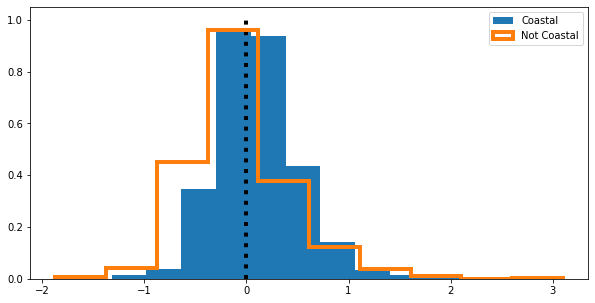

In [7]:
is_coastal = db.coastal.astype(bool)

coastal = m1.u[is_coastal]      #errores cuando es costa
not_coastal = m1.u[~is_coastal] #errores cuando NO es costa

plt.hist(
    coastal, 
    density=True, 
    label='Coastal'
)
plt.hist(
    not_coastal, 
    histtype='step',
    density=True, 
    linewidth=4, 
    label='Not Coastal'
)
plt.vlines(0,0,1, linestyle=":", color='k', linewidth=4)
plt.legend()
plt.show()

Si bien parece que los vecindarios de la costa tienen solo errores promedio ligeramente más altos (y tienen una menor varianza en sus errores de predicción), las dos distribuciones son significativamente distintas entre sí cuando se comparan utilizando un modelo clásico t-test:

In [8]:
stats.ttest_ind(coastal, not_coastal)

Ttest_indResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]))

Sin embargo, existen **pruebas más sofisticadas** (y más difíciles de engañar) que pueden ser aplicables para estos datos. Los cubrimos **en la sección Desafío**.

---

Además, **podría darse el caso de que algunos vecindarios sean más deseables que otros debido a preferencias latentes no modeladas o marketing**. Por ejemplo, a pesar de su presencia cerca del mar, vivir cerca de Camp Pendleton -una base de la Marina en el norte de la ciudad- puede incurrir en algunas sanciones importantes en la conveniencia del área debido al ruido y la contaminación. Para que podamos determinar si este es el caso, podríamos estar interesados en la **distribución completa de los residuos del modelo dentro de cada vecindario**.

Para aclarar esto, **primero ordenaremos los datos por el residuo mediano en ese vecindario y luego haremos un diagrama de caja, que muestra la distribución de los residuos en cada vecindario**:

C:\Users\Julen Montes\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


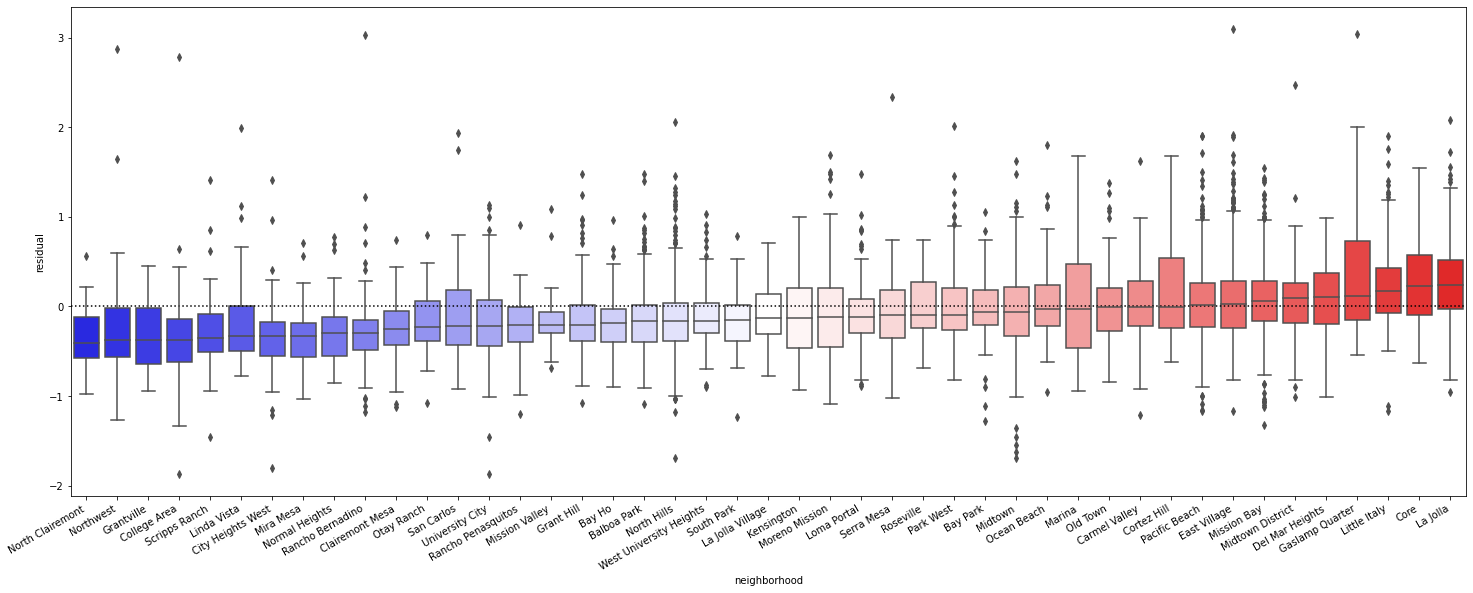

In [9]:
db['residual'] = m1.u
medians = db.groupby(
    "neighborhood"
).residual.median().to_frame(
    'hood_residual'
)

f = plt.figure(figsize=(25,10))
ax = plt.gca()
seaborn.boxplot(
    'neighborhood', 
    'residual', 
    ax = ax,
    data=db.merge(
        medians, 
        how='left',
        left_on='neighborhood',
        right_index=True
    ).sort_values(
        'hood_residual'), palette='bwr'
)
f.autofmt_xdate()
plt.hlines(0,-0.5,44.5,'black','dotted')
plt.show()

Analizamos la mediana

In [12]:
medians.sort_values('hood_residual')

,hood_residual
neighborhood,
North Clairemont,-0.405469
Northwest,-0.378295
Grantville,-0.375752
College Area,-0.374717
Scripps Ranch,-0.354086
Linda Vista,-0.330121
City Heights West,-0.326998
Mira Mesa,-0.326998
Normal Heights,-0.300446


Ningún vecindario está dislocado entre sí, pero **algunos parecen ser más altos que otros, como las conocidas áreas de vecindarios turísticos del centro de Gaslamp Quarter, Little Italy o The Core**. Por lo tanto, puede haber un efecto distintivo de la moda intangible del vecindario que importa en este modelo.

Teniendo en cuenta que muchos de los vecindarios más predichos y menos predichos están cerca unos de otros en la ciudad, también puede darse el caso de que haya **algún tipo de contagio o desbordes espaciales en el precio del alquiler nocturno**. Esto a menudo es evidente cuando las personas buscan fijar el precio de sus anuncios de AirBnB para competir con anuncios similares cercanos. Dado que nuestro modelo no es consciente de este comportamiento, sus errores pueden tender a agruparse. **Una forma excepcionalmente sencilla de examinar esta estructura es examinando la relación entre los residuos de una observación y los residuos que la rodean**.

Para hacer esto, usaremos **pesos espaciales para representar las relaciones geográficas** entre las observaciones. Cubrimos los pesos espaciales en detalle en otro capítulo, por lo que no nos repetiremos aquí. Para este ejemplo, comenzaremos con una **matriz KNN  donde k=1, lo que significa que nos estamos enfocando solo en los vínculos de cada AirBnB con su otra lista más cercana**.

In [13]:
knn = weights.KNN.from_dataframe(db, k=1)

C:\Users\Julen Montes\Anaconda\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 1849 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


Esto significa que, cuando calculamos el retraso espacial de ese peso y el residuo de KNN, obtenemos el residuo del listado AirBnB más cercano a cada observación.

C:\Users\Julen Montes\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


TypeError: 'Text' object is not callable

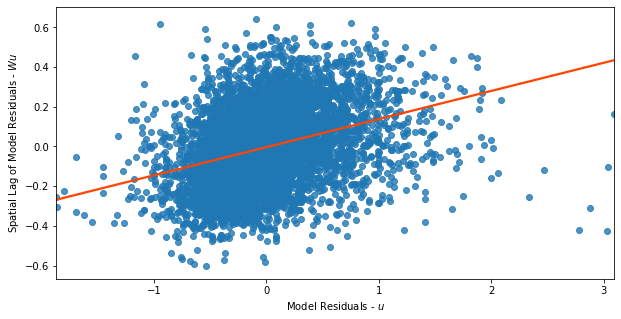

In [44]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    m1.u.flatten(),         #residuos
    lag_residual.flatten(), #residuos en sus vecinos
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');
ax

En esta gráfica, vemos que **nuestros errores de predicción tienden a agruparse**. Arriba, mostramos la relación entre nuestro error de predicción en cada sitio y el error de predicción en el sitio más cercano. Aquí, estamos usando este sitio más cercano para representar los alrededores de ese AirBnB. **Esto significa que, cuando el modelo tiende a predecir en exceso el precio de registro nocturno de un AirBnB determinado, es más probable que los sitios alrededor de ese AirBnB también se predigan en exceso**.

Una propiedad interesante de esta relación es que tiende a estabilizarse a medida que aumenta el número de vecinos más cercanos utilizados para construir los alrededores de cada AirBnB. Consulte la sección Desafío para obtener más información sobre esta propiedad.

Dado este comportamiento, veamos el establo k=20 numero de vecinos. Al examinar la relación entre este promedio circundante estable y el AirBnB focal, incluso podemos encontrar clústeres en nuestro error de modelo. Recordando las estadísticas locales de Moran, podemos identificar ciertas áreas donde nuestras predicciones del precio nocturno (log) de AirBnB tienden a ser significativamente diferentes:

In [ ]:
knn.reweight(k=20, inplace=True)
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
error_clusters = (outliers.q % 2 == 1) # only the cluster cores
error_clusters &= (outliers.p_sim <= .001) # filtering out non-significant clusters

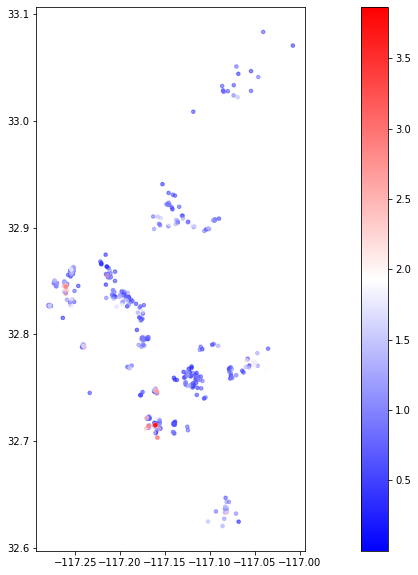

In [33]:
db.assign(
    error_clusters = error_clusters,
    local_I = outliers.Is
).query(
    "error_clusters"
).sort_values(
    'local_I'
).plot(
    'local_I', cmap='bwr', marker='.', figsize=(20,10), legend=True, markersize=50, alpha=0.5
);

Por lo tanto, estas áreas tienden a ser ubicaciones donde nuestro modelo predice significativamente el precio de AirBnB nocturno tanto para esa observación específica como para las observaciones en su entorno inmediato. Esto es fundamental ya que, si podemos identificar cómo están estructuradas estas áreas, si tienen una geografía consistente que podamos modelar, entonces podríamos hacer nuestras predicciones aún mejores, o al menos no predecir sistemáticamente los precios en algunas áreas mientras predicemos correctamente. Precios en otras áreas.

**Dado que las predicciones insuficientes y excesivas significativas parecen agruparse de una manera muy estructurada, es posible que podamos usar un modelo mejor para corregir la geografía de los errores de nuestro modelo.**

## Llevando espacio al marco de regresión 


Hay muchas formas diferentes en que la estructura espacial se muestra en nuestros modelos, predicciones y nuestros datos, incluso si no tenemos la intención explícita de estudiarla. Afortunadamente, existen casi la misma cantidad de técnicas, llamadas métodos de regresión espacial, que están diseñadas para manejar este tipo de estructuras. 
**La regresión espacial** se trata explícitamente de **introducir el espacio o el contexto geográfico en el marco estadístico de una regresión**. Conceptualmente, queremos introducir espacio en nuestro modelo siempre que pensamos que juega un papel importante en el proceso que nos interesa, o cuando el espacio puede actuar como un proxy razonable para otros factores que no podemos pero debemos incluir en nuestro modelo. Como ejemplo de lo primero, podemos imaginar cómo las casas en primera línea de mar son probablemente más caras que las de la segunda fila, dadas sus mejores vistas. Para ilustrar esto último, podemos pensar en cómo el carácter de un vecindario es importante para determinar el precio de una casa; sin embargo, es muy difícil identificar y cuantificar el "carácter" per se, aunque podría ser más fácil llegar a su variación espacial, de ahí un caso de espacio como proxy.

La regresión espacial es un gran campo de desarrollo en la literatura sobre econometría y estadística. En esta breve introducción, consideraremos dos procesos relacionados pero muy diferentes que dan lugar a efectos espaciales: la **heterogeneidad espacial** y la **dependencia espacial**. Para un tratamiento más riguroso de los temas presentados aquí, se remite al lector a [ Ans03 , AR14 , GH06 ] .



### Ingeniería de características espaciales

El **uso de información geográfica para "construir" nuevos datos** es un enfoque común **para incorporar información espacial en el análisis geográfico**. A menudo, esto refleja el hecho de que los procesos no son los mismos en todas partes del mapa de análisis, o que la información geográfica puede ser útil para predecir nuestro resultado de interés. En esta sección, presentaremos brevemente **cómo usar las características espaciales , o 'X' variables que se construyen a partir de relaciones geográficas**, en un modelo lineal estándar. Sin embargo, discutiremos ampliamente la ingeniería de características espaciales en el próximo capítulo, y la profundidad y extensión de la ingeniería de características espaciales es difícil de exagerar. En esto, consideraremos solo las características espaciales más simples: **variables de proximidad**.

- **Variables de proximidad** 

Para empezar, una variable relevante impulsada por la proximidad que podría influir en nuestro modelo se basa en la **proximidad de los listados al Parque Balboa**. Un **destino turístico** común, el parque Balboa es un centro de recreación central para la ciudad de San Diego, que contiene muchos museos y el zoológico de San Diego. Por lo tanto, podría darse el caso de que las personas que buscan AirBnB en San Diego estén dispuestas a pagar una prima para vivir más cerca del parque. Si esto fuera cierto y lo omitimos de nuestro modelo, de hecho podríamos ver un patrón espacial significativo causado por este efecto de disminución de la distancia.

Por lo tanto, esto a veces se denomina **covariable omitida** con patrón espacial: **información geográfica que nuestro modelo necesita para hacer buenas predicciones que hemos dejado fuera de nuestro modelo**. Por lo tanto, construyamos un nuevo modelo que contenga esta distancia a la covariable del Parque Balboa. 

Primero, sin embargo, ayuda visualizar la estructura de esta covariable de distancia en sí misma:

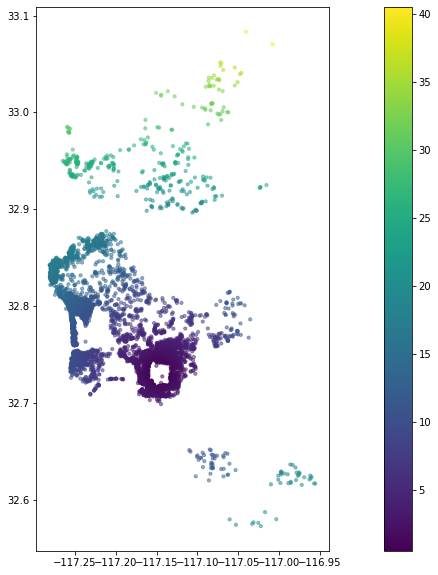

In [31]:
db.plot('d2balboa', marker='.', s=5, figsize=(20,10),legend=True,markersize=40,alpha=0.5);

Añadimos balboa

In [34]:
base_names = variable_names
balboa_names = variable_names + ['d2balboa']

Reentrenamos el modelo

In [37]:
m2 = spreg.OLS(
    db[['log_price']].values, 
    db[balboa_names].values, 
    name_y = 'log_price', 
    name_x = balboa_names
)

Desafortunadamente, cuando inspecciona los diagnósticos de regresión y la salida, ve que esta covariable no es tan útil como podríamos anticipar. 

**No es estadísticamente significativo a niveles de significancia convencionales, el ajuste del modelo (R2 adj) no cambia sustancialmente:**



In [38]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6098
R-squared           :      0.6685
Adjusted R-squared  :      0.6679
Sum squared residual:    1319.522                F-statistic           :   1117.9338
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3987.446
Sigma-square ML     :       0.216                Akaike info criterion :    7998.892
S.E of regression ML:      0.4647                Schwarz criterion     :    8079.504

-----------------------------------------------------------------------------

Y, todavía parece haber una estructura espacial en los errores de nuestro modelo:

In [43]:
m2

C:\Users\Julen Montes\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


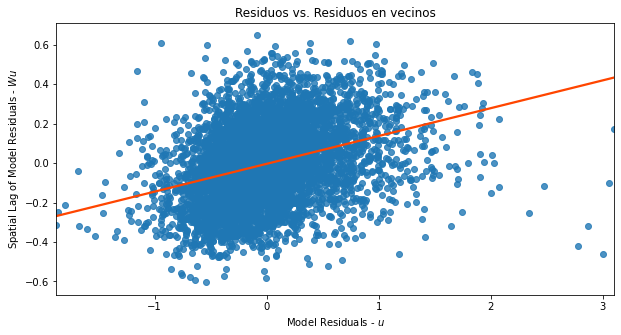

In [49]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
seaborn.regplot(
    m2.u.flatten(),         #residuos
    lag_residual.flatten(), #residuos en sus vecinos
    line_kws=dict(color='orangered'),
    ci=None
);
plt.xlabel('Model Residuals - $u$')
plt.ylabel('Spatial Lag of Model Residuals - $W u$')
plt.title('Residuos vs. Residuos en vecinos');

Por último, **la variable de distancia al Parque Balboa no se ajusta a nuestra teoría sobre cómo la distancia a las comodidades debería afectar el precio de un AirBnB**; la estimación del coeficiente es positiva, lo que significa que la gente está pagando una prima por estar más lejos del parque. Revisaremos este resultado más adelante, cuando consideremos la heterogeneidad espacial y podamos arrojar algo de luz sobre esto. Además, el próximo capítulo es un tratamiento extenso de los efectos fijos espaciales, presentando muchos más métodos de ingeniería de características espaciales. Aquí, solo hemos mostrado cómo incluir estas características diseñadas en un marco de modelado lineal estándar.



### Heterogeneidad espacial

Aunque hemos asumido que nuestra variable de proximidad podría representar una prima difícil de medir que pagan las personas cuando están cerca de una zona recreativa. Sin embargo, no todos los barrios son iguales; algunos vecindarios pueden ser más lucrativos que otros, independientemente de su proximidad al Parque Balboa. Cuando este es el caso, **necesitamos alguna forma de explicar el hecho de que cada vecindario puede experimentar este tipo de gestalt , efectos únicos**. 

**Una forma de hacer esto es capturar la heterogeneidad espacial**. En su forma más básica, la heterogeneidad espacial significa que **partes del modelo pueden cambiar en diferentes lugares**. 

    Por ejemplo, cambios en la intersección,α, puede reflejar el hecho de que diferentes áreas tienen diferentes exposiciones de línea de base a un proceso dado. Cambios en los términos de la pendiente,β, puede indicar algún tipo de factor de mediación geográfico, como cuando una política gubernamental no se aplica de manera uniforme en todas las jurisdicciones. Finalmente, los cambios en la varianza de los residuales, comúnmente denominados σ2, puede introducir heterocedasticidad espacial. Nos ocupamos de los dos primeros en esta sección.

Para ilustrar los efectos fijos espaciales, consideremos el ejemplo del precio de la vivienda de la sección anterior para presentar una ilustración más general del “espacio como proxy”. Dado que solo incluimos dos variables explicativas en el modelo, es probable que nos falten algunos factores importantes que influyen en la determinación del precio al que se vende una casa. Sin embargo, es probable que algunos de ellos varíen sistemáticamente a lo largo del espacio (por ejemplo, diferentes características del vecindario). Si ese es el caso, podemos controlar esos factores no observados mediante el uso de variables ficticias tradicionales pero basando su creación en una regla espacial. Por ejemplo, ****incluyamos una variable binaria para cada vecindario, indicando si una casa dada está ubicada dentro de dicha área ( 1) o no ( 0)**. Matemáticamente, ahora estamos ajustando la siguiente ecuación:

    logPi = αr + ∑k.Xik.βk + ϵi

    donde la principal diferencia es que ahora permitimos el término constante, α, para variar según el vecindario r, αr.

Programáticamente, mostraremos dos formas diferentes de estimar esto: **una, usando statsmodels**; y **dos, con PySAL**. Primero, usaremos statsmodels. Este paquete proporciona una API similar a una fórmula, que nos permite expresar la ecuación que deseamos estimar directamente:

In [55]:
f = 'log_price ~ ' + ' + '.join(variable_names) + ' + neighborhood - 1'
print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


El operador de tilde en esta declaración generalmente se lee como "el precio del registro es una función de ...", para tener en cuenta el hecho de que se pueden ajustar muchas especificaciones de modelo diferentes de acuerdo con esa relación funcional entre log_price y nuestra lista de covariables. Críticamente, tenga en cuenta que **el -1 término final significa que estamos ajustando este modelo sin un término de intersección**. 

**Esto es necesario, ya que incluir un término de intersección junto con medios únicos para cada vecindario haría que el sistema subyacente de ecuaciones no se especificara demasiado**. En este caso, la constante se especificará mediante la pertenencia a un barrio determinado

Usando esta expresión, podemos estimar los efectos únicos de cada vecindario, ajustando el modelo en statsmodels:

In [56]:
m3 = sm.ols(f, data=db).fit()
print(m3.summary2())

                           Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.709    
Dependent Variable:         log_price              AIC:                      7229.6640
Date:                       2021-05-19 15:50       BIC:                      7599.1365
No. Observations:           6110                   Log-Likelihood:           -3559.8  
Df Model:                   54                     F-statistic:              276.9    
Df Residuals:               6055                   Prob (F-statistic):       0.00     
R-squared:                  0.712                  Scale:                    0.18946  
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------------
neighborhood[Balboa Park]              4.2808   0.0333 128.5836 0.0000 

El enfoque anterior muestra cómo la EF espacial es un caso particular de una **regresión lineal con una variable categórica**. **La pertenencia al vecindario se modela utilizando variables ficticias binarias**. Gracias a la gramática de fórmulas utilizada statsmodels, podemos expresar el modelo de forma abstracta, y Python lo analiza, creando adecuadamente las variables binarias según sea necesario.

El segundo enfoque aprovecha la PySAL funcionalidad de los regímenes, que permite al usuario especificar qué variables se estimarán por separado para cada "régimen". Sin embargo, en este caso, en lugar de describir el modelo en una fórmula, necesitamos pasar cada elemento del modelo como argumentos separados.

In [57]:
# PySAL implementation
m4 = spreg.OLS_Regimes(
    db[['log_price']].values, 
    db[variable_names].values,
    db['neighborhood'].tolist(),
    constant_regi  = 'many',
    cols2regi      = [False]*len(variable_names),
    regime_err_sep = False,
    name_y         = 'log_price', 
    name_x         = variable_names
)
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          55
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6055
R-squared           :      0.7118
Adjusted R-squared  :      0.7092
Sum squared residual:    1147.169                F-statistic           :    276.9408
Sigma-square        :       0.189                Prob(F-statistic)     :           0
S.E. of regression  :       0.435                Log likelihood        :   -3559.832
Sigma-square ML     :       0.188                Akaike info criterion :    7229.664
S.E of regression ML:      0.4333                Schwarz criterion     :    7599.137

---------------------------------------------------------

**Econométricamente hablando, lo que implican las FE de vecindario que hemos introducido es que, en lugar de comparar todos los precios de la vivienda en San Diego como iguales, solo obtenemos variaciones dentro de cada código postal**. Recuerde que la interpretación de βk es el efecto de la variable k, dado que todas las demás variables explicativas incluidas permanecen constantes. Al incluir una sola variable para cada área, efectivamente estamos forzando al modelo a comparar como iguales solo los precios de la vivienda que comparten el mismo valor para cada variable; o, en otras palabras, solo viviendas ubicadas dentro de la misma zona. 

**La introducción de FE permite un mayor grado de aislamiento de los efectos de las variables que introducimos en el modelo porque podemos controlar los efectos no observados que se alinean espacialmente con la distribución de la FE introducida (por código postal, en nuestro caso).**

Para hacer un mapa de efectos fijos de vecindad, necesitamos procesar ligeramente los resultados de nuestro modelo.

Primero, extraemos solo los efectos pertenecientes a los barrios:

In [63]:
neighborhood_effects = m3.params.filter(like='neighborhood')
neighborhood_effects

neighborhood[Balboa Park]                4.280766
neighborhood[Bay Ho]                     4.198251
neighborhood[Bay Park]                   4.329223
neighborhood[Carmel Valley]              4.389261
neighborhood[City Heights West]          4.053518
neighborhood[Clairemont Mesa]            4.095259
neighborhood[College Area]               4.033697
neighborhood[Core]                       4.726186
neighborhood[Cortez Hill]                4.608090
neighborhood[Del Mar Heights]            4.496910
neighborhood[East Village]               4.545469
neighborhood[Gaslamp Quarter]            4.775799
neighborhood[Grant Hill]                 4.306742
neighborhood[Grantville]                 4.053298
neighborhood[Kensington]                 4.302671
neighborhood[La Jolla]                   4.682084
neighborhood[La Jolla Village]           4.330311
neighborhood[Linda Vista]                4.191149
neighborhood[Little Italy]               4.666742
neighborhood[Loma Portal]                4.301909


Luego, necesitamos extraer solo el nombre del vecindario del índice de esta Serie. Una forma sencilla de hacer esto es quitar todos los personajes que vienen antes y después de los nombres de nuestros vecindarios:

In [64]:
stripped = neighborhood_effects.index.str.strip('neighborhood[').str.strip(']')
neighborhood_effects.index = stripped
neighborhood_effects = neighborhood_effects.to_frame('fixed_effect')
neighborhood_effects

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518
Clairemont Mesa,4.095259
College Area,4.033697
Core,4.726186
Cortez Hill,4.608090
Del Mar Heights,4.496910


Bien, volvemos a los nombres crudos de nuestros vecindarios. Ahora, podemos volver a unirlos con las formas de vecindario:

In [68]:
# import requests
# url = 'http://data.insideairbnb.com/united-states/'\
#       'ca/san-diego/2016-07-07/visualisations/'\
#       'neighbourhoods.geojson'
# r = requests.get(url)
# with open('data/neighbourhoods.geojson', 'wb') as fo:
#     fo.write(r.content)

In [69]:
sd_path = './data/neighbourhoods.geojson'
neighborhoods = geopandas.read_file(sd_path)

Pintamos efecto fijo de cada vecindario

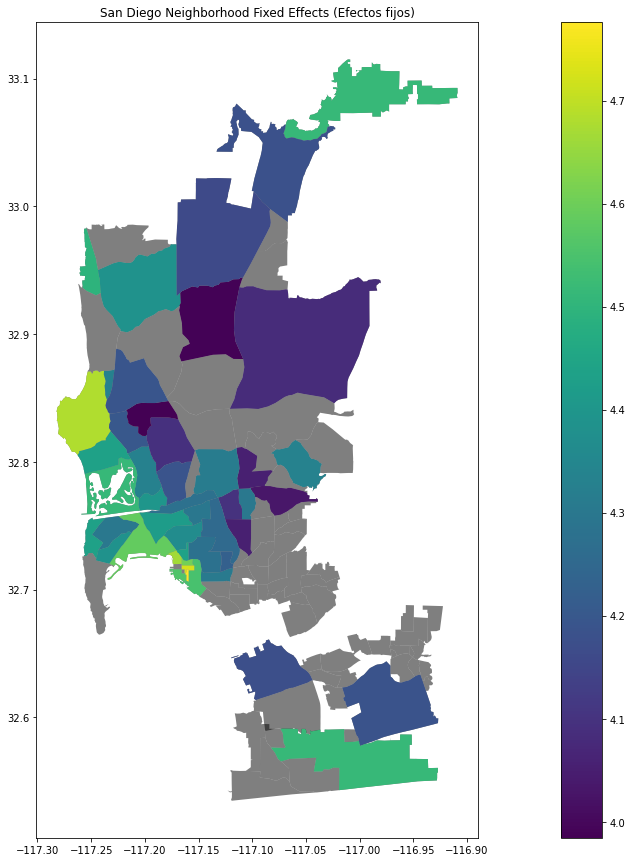

In [76]:
ax = neighborhoods.plot(
    color='k', alpha=0.5, figsize=(30,15)
)
neighborhoods.merge(
    neighborhood_effects, 
    how='left',
    left_on='neighbourhood', 
    right_index=True
).dropna(
    subset=['fixed_effect']
).plot(
    'fixed_effect', ax=ax, legend=True
)
ax.set_title("San Diego Neighborhood Fixed Effects (Efectos fijos)")
plt.show()

### Regímenes espaciales

En el centro de la estimación de las FE (Feature Enginnering) espaciales se encuentra la idea de que, **en lugar de asumir que la variable dependiente se comporta de manera uniforme en el espacio, existen efectos sistemáticos que siguen un patrón geográfico que afectan su comportamiento**. En otras palabras, **las FE espaciales introducen econométricamente la noción de heterogeneidad espacial**. Lo hacen de la forma más simple posible: permitiendo que el término constante varíe geográficamente. Los otros elementos de la regresión no se modifican y, por lo tanto, se aplican uniformemente en todo el espacio. La idea de los regímenes espaciales (SR) es generalizar el enfoque de FE espacial para permitir que no solo varíe el término constante, sino también cualquier otra variable explicativa. Esto implica que la ecuación que estaremos estimando es:

    logPi = αr + ∑k Xki.βk−r + ϵi

    donde no solo permitimos que el término constante varíe según la región (αr), sino también cualquier otro parámetro (βk−r).

Para ilustrar este enfoque, usaremos el **“diferenciador espacial”** de **si una casa está en un vecindario costero o no ( coastal_neig) para definir los regímenes**. La razón fundamental detrás de esta elección es que alquilar una casa cerca del mar podría ser un atractivo lo suficientemente fuerte como para que la gente esté dispuesta a pagar a diferentes tarifas por cada una de las características de la casa.

Para implementar esto en Python, usamos la OLS_Regimes clase in PySAL, que hace la mayor parte del trabajo pesado por nosotros:

In [78]:
m4 = spreg.OLS_Regimes(
    db[['log_price']].values, 
    db[variable_names].values,
    db['coastal'].tolist(),
    constant_regi    = 'many',
    regime_err_sep   = False,
    name_y           = 'log_price', 
    name_x           = variable_names
)
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          22
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6088
R-squared           :      0.6853
Adjusted R-squared  :      0.6843
Sum squared residual:    1252.489                F-statistic           :    631.4283
Sigma-square        :       0.206                Prob(F-statistic)     :           0
S.E. of regression  :       0.454                Log likelihood        :   -3828.169
Sigma-square ML     :       0.205                Akaike info criterion :    7700.339
S.E of regression ML:      0.4528                Schwarz criterion     :    7848.128

---------------------------------------------------------

### Dependencia espacial

Como acabamos de comentar, SH se trata de efectos de fenómenos que están explícitamente vinculados a la geografía y que, por tanto, provocan variación espacial y agrupamiento. Esto abarca muchos de los tipos de efectos espaciales que pueden interesarnos cuando ajustamos regresiones lineales. Sin embargo, en otros casos, nuestro enfoque está en el efecto de la configuración espacialde las observaciones, y la medida en que eso tiene un efecto en el resultado que estamos considerando. Por ejemplo, podríamos pensar que el precio de una casa no solo depende de si es una casa adosada o un apartamento, sino también de si está rodeada de muchas más casas adosadas que rascacielos con más apartamentos. Esto, podríamos suponer, podría estar relacionado con el diferente "aspecto y sensación" que tiene un vecindario con edificios históricos de baja altura en comparación con uno con rascacielos modernos. En la medida en que estas dos configuraciones espaciales diferentes entren de manera diferente en el proceso de determinación del precio de la vivienda, nos interesará captar no solo las características de una casa, sino también de las que la rodean. Este tipo de efecto espacial es fundamentalmente diferente del SH en que no está relacionado con las características inherentes de la geografía, sino con las características de las observaciones en nuestro conjunto de datos y, especialmente, con su disposición espacial. Llamamos a este fenómeno por el cual los valores de las observaciones se relacionan entre sí a través de la distancia.dependencia espacial [ Ans88 ] .

Hay varias formas de introducir la dependencia espacial en un marco econométrico, con diversos grados de sofisticación econométrica (ver [ Ans02 ] para una buena descripción general). Sin embargo, común a todos ellos es la forma en que el espacio se encapsula formalmente: a través de matrices de ponderaciones espaciales (W) , que discutimos en el Capítulo 4.

**Efectos exógenos: el modelo SLX**

Volvamos al ejemplo del precio de la vivienda con el que hemos estado trabajando. Hasta ahora, hemos planteado la hipótesis de que el precio de una casa alquilada en San Diego a través de AirBnB puede explicarse utilizando información sobre sus propias características así como algunas relativas a su ubicación como el barrio o la distancia al parque principal de la ciudad. Sin embargo, también es razonable pensar que los posibles inquilinos se preocupan por el área más grande alrededor de una casa, no solo por la casa en sí, y estarían dispuestos a pagar más por una casa rodeada por ciertos tipos de casas, y menos si estaba ubicado en medio de otros tipos. ¿Cómo podríamos probar esta idea?

La forma más sencilla de introducir la dependencia espacial en una regresión es considerando no solo una variable explicativa dada, sino también su rezago espacial. En nuestro caso de ejemplo, además de incluir una variable ficticia para el tipo de vivienda ( pg_XXX), también podemos incluir el rezago espacial de cada tipo de vivienda. Esta adición implica que también estamos incluyendo como factor explicativo del precio de una vivienda determinada la proporción de viviendas vecinas en cada tipo. Matemáticamente, esto implica estimar el siguiente modelo:

log(Pi)=α+∑k=1pXijβj+∑k=1p(∑j=1Nwijxjk)γk+ϵi
dónde ∑Nj=1wijxjk representa el desfase espacial del kª variable explicativa. Esto se puede establecer en forma de matriz utilizando la matriz de ponderaciones espaciales,W, como: $log(Pi)=α+Xβ+WXγ+ϵPS

Esto divide el modelo para centrarse en dos efectos principales: β y γ. La β efecto describe el cambio en yi Cuándo Xikcambios en uno. ^ [Dado que usamos el precio del registro para uny variable, nuestro βLos coeficientes todavía se interpretan como elasticidades , lo que significa que un cambio unitario en elxi resultados variables en un βcambio porcentual en el precio y_i ]. El subíndice del sitioi es importante aquí: dado que estamos tratando con un W matriz, es útil tener claro dónde se produce el cambio.

De hecho, esto es importante para el γefecto, que representa un efecto indirecto de un cambio enXi. Esto se puede conceptualizar de dos formas. Primero, uno podría pensar enγsimplemente como el efecto de un cambio de unidad en su entorno promedio. Esto es útil y sencillo. Pero esta interpretación ignora dónde podría ocurrir este cambio. En verdad, un cambio en una variable en el sitio.iresultará en un derrame a su entorno: cuandoxicambia, también lo hace el retraso espacial de cualquier sitio cercai. El tamaño exacto de este dependerá de la estructura deWy puede ser diferente para cada sitio. Por ejemplo, piense en un sitio "focal" muy conectado en una matriz de peso estandarizada por filas. Este sitio focal no se verá muy afectado si un vecino cambia en una sola unidad, ya que cada sitio solo contribuye una pequeña cantidad al retraso en el sitio focal. Alternativamente, considere un sitio con un solo vecino: su retraso cambiará exactamente en la cantidad que cambie su único vecino. Por lo tanto, para descubrir el efecto indirecto exacto de un cambioy causado por el cambio en un sitio específico xinecesitaría calcular el cambio en el retraso espacial , y luego usarlo como su cambio enX. Discutiremos esto en la siguiente sección.

En Python, podemos calcular el retraso espacial de cada variable cuyo nombre comienza pg_ creando primero una lista de todos esos nombres y luego aplicando PySAL los lag_spatial de cada uno de ellos:

In [82]:
wx = db.filter(
    like='pg'
).apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
).rename(
    columns=lambda c: 'w_'+c
).drop(
    'w_pg_Apartment', axis=1
)
wx

,w_pg_Condominium,w_pg_House,w_pg_Other,w_pg_Townhouse
0,0.00,0.45,0.20,0.00
1,0.30,0.35,0.00,0.05
2,0.05,0.30,0.00,0.05
3,0.00,0.95,0.00,0.05
4,0.05,0.85,0.00,0.00
...,...,...,...,...
6105,0.30,0.05,0.00,0.00
6106,0.05,0.00,0.60,0.00
6107,0.00,0.55,0.25,0.00
6108,0.00,0.05,0.05,0.00


Una vez calculado, podemos ejecutar el modelo utilizando la estimación de OLS porque, en este contexto, los rezagos espaciales incluidos no violan ninguno de los supuestos en los que se basa OLS (son esencialmente variables exógenas adicionales):

In [81]:
slx_exog = db[variable_names].join(wx)
m5 = spreg.OLS(
    db[['log_price']].values, 
    slx_exog.values,
    name_y='l_price', 
    name_x=slx_exog.columns.tolist()
)
print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     l_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          15
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6095
R-squared           :      0.6800
Adjusted R-squared  :      0.6792
Sum squared residual:    1273.933                F-statistic           :    924.9423
Sigma-square        :       0.209                Prob(F-statistic)     :           0
S.E. of regression  :       0.457                Log likelihood        :   -3880.030
Sigma-square ML     :       0.208                Akaike info criterion :    7790.061
S.E of regression ML:      0.4566                Schwarz criterion     :    7890.826

-----------------------------------------------------------------------------

La forma de interpretar la tabla de resultados es similar a la de cualquier otra regresión no espacial. Las variables que incluimos en la regresión original muestran un comportamiento similar, aunque con pequeños cambios de tamaño, y pueden interpretarse también de manera similar. El retraso espacial de cada tipo de propiedad ( w_pg_XXX) es la nueva adición. **Observamos que, a excepción del caso de las casas adosadas (al igual que con la variable binaria, pg_Townhouse), todas son significativas, lo que sugiere que nuestra hipótesis inicial sobre el papel de las casas circundantes podría estar en juego aquí.**

Como ilustración, veamos algunos de los efectos directos / indirectos. **El efecto directo de la pg_Condominium variable significa que los condominios suelen ser un 11% más caros (βpg_Condominium=0.1063) que el tipo de propiedad de referencia, apartamentos.** Más relevante para esta sección, cualquier casa rodeada de condominios también recibe un sobreprecio. Pero desde pgCondominium es una variable ficticia, el retraso espacial en el sitio irepresenta el porcentaje de propiedades cerca i que son condominios, que se encuentra entre 0 y 1. ^ [Descubra esto por sí mismo: ¿cuál es el promedio de ?] Entonces, un cambio de unidad en esta variable significa que aumentaría el porcentaje de condominio en un 100%. Por lo tanto, un numpy.array([True, True, True, False, False, True)].1 un aumento en w_pg_Condominium (un cambio de diez puntos porcentuales) resultaría en un aumento del 5.92% en el precio de la vivienda de la propiedad (βwpg_Condominium=0.6). Se pueden derivar interpretaciones similares para todas las demás variables con retraso espacial para derivar el efecto indirecto de un cambio en el retraso espacial.

Sin embargo, para calcular el cambio indirecto para un sitio determinado i, es posible que deba examinar los valores predichos para yi. En este ejemplo, dado que estamos usando una matriz de ponderaciones estandarizadas por filas con veinte vecinos más cercanos, el impacto de cambiar xi es igual para todos sus vecinos y para cualquier sitio i. Por tanto, el efecto es siempre γ/20, o sobre 0.0296. Sin embargo, esto no sería lo mismo para muchos otros tipos de pesas (como Kernel, Queen, Rook, DistanceBand, o Voronoi), por lo que vamos a demostrar cómo construir el efecto indirecto de una específica i:

Primero, valores predichos para yi se almacenan en el predy atributo de cualquier modelo:

In [83]:
m5.predy

array([[5.43610121],
       [5.38596868],
       [4.25377454],
       ...,
       [4.29145318],
       [4.89174746],
       [4.85867698]])

Para construir nuevas predicciones, debemos seguir la ecuación indicada anteriormente.

Mostrando este proceso a continuación, primero cambiemos una propiedad para que sea un condominio. Considere la tercera observación, que es el primer apartamento en los datos:

In [84]:
db.loc[2]

accommodates                                                     2
bathrooms                                                      1.0
bedrooms                                                       1.0
beds                                                           1.0
neighborhood                                           North Hills
pool                                                             0
d2balboa                                                  2.493893
coastal                                                          0
price                                                         99.0
log_price                                                  4.59512
id                                                            9553
pg_Apartment                                                     1
pg_Condominium                                                   0
pg_House                                                         0
pg_Other                                                      

Este es un apartamento. Hagamos una copia de nuestros datos y cambiemos este apartamento en un condominio:

In [85]:
db_scenario = db.copy()
# make Apartment 0 and condo 1
db_scenario.loc[2, ['pg_Apartment', 'pg_Condominium']] = [0,1]

In [86]:
db_scenario.loc[2]

accommodates                                                     2
bathrooms                                                      1.0
bedrooms                                                       1.0
beds                                                           1.0
neighborhood                                           North Hills
pool                                                             0
d2balboa                                                  2.493893
coastal                                                          0
price                                                         99.0
log_price                                                  4.59512
id                                                            9553
pg_Apartment                                                     0
pg_Condominium                                                   1
pg_House                                                         0
pg_Other                                                      

Ahora, también necesitamos actualizar las variaciones de retardo espacial:


In [87]:
wx_scenario = db_scenario.filter(
    like='pg'
).apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
).rename(
    columns=lambda c: 'w_'+c
).drop(
    'w_pg_Apartment', axis=1
)

Y construir un nuevo exógeno X matriz, incluida la constante a 1 como columna principal

In [88]:
slx_exog_scenario = db_scenario[variable_names].join(wx_scenario)


Ahora, nuestra nueva predicción (en el escenario en el que hemos cambiado el sitio 2de un apartamento a un condominio) es:

In [89]:
y_pred_scenario = m5.betas[0] + slx_exog_scenario @ m5.betas[1:]


Esta predicción será exactamente la misma para todos los sitios, excepto el sitio 2 y sus vecinos. Entonces, los vecinos del sitio 2 son:

In [90]:
knn.neighbors[2]

[772,
 2212,
 139,
 4653,
 2786,
 1218,
 138,
 808,
 1480,
 4241,
 1631,
 3617,
 2612,
 1162,
 135,
 23,
 5528,
 3591,
 407,
 6088]

Y el efecto de cambiar de sitio 2 a un condominio está asociado con los siguientes cambios en yk:

In [92]:
(y_pred_scenario - m5.predy).loc[[2] + knn.neighbors[2]]

,0
2,0.106349
772,0.029642
2212,0.029642
139,0.029642
4653,0.029642
2786,0.029642
1218,0.029642
138,0.029642
808,0.029642
1480,0.029642


Vemos que la primera fila, que representa el efecto directo, es exactamente igual a la estimación de pg_Condominium. Para los otros efectos, sin embargo, solo hemos cambiado w_pg_Condominiumpor.05

In [93]:
scenario_near_2 = slx_exog_scenario.loc[knn.neighbors[2], ['w_pg_Condominium']]
orig_near_2 = slx_exog.loc[knn.neighbors[2], ['w_pg_Condominium']]
scenario_near_2.join(orig_near_2, lsuffix='_scenario', rsuffix= '_original')

,w_pg_Condominium_scenario,w_pg_Condominium_original
772,0.10,0.05
2212,0.10,0.05
139,0.10,0.05
4653,0.10,0.05
2786,0.10,0.05
1218,0.10,0.05
138,0.10,0.05
808,0.05,0.00
1480,0.10,0.05
4241,0.10,0.05
